In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('hh_ru_dataset.csv')

# Обработка пустых значений

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   topic_id                 500000 non-null  object 
 1   topic_creation_date      500000 non-null  object 
 2   initial_state            499166 non-null  object 
 3   final_state              499166 non-null  object 
 4   resume_id                500000 non-null  object 
 5   resume_creation_date     500000 non-null  object 
 6   profession               500000 non-null  object 
 7   gender                   500000 non-null  object 
 8   year_of_birth            500000 non-null  int64  
 9   resume_region            500000 non-null  object 
 10  education_level          499898 non-null  object 
 11  expected_salary          489214 non-null  float64
 12  relocation_status        500000 non-null  object 
 13  business_trip_readiness  500000 non-null  object 
 14  work

Смело удалаяем строки с пустыми initial_state, final_state, education_level. По поводу остальных вопрос. Nan в resume_skills_list - это просто пустой список как я понял; предлагаемая зарплата вакансии отсутствует где-то, но это норм по идее.

In [3]:
"""Остались Nan'ы в столбцах ожидаемой зарплаты, графика, границ предлагаемой зп вакансии. В случае 
гипотезы по этим параметрам не забыть удалить их.
"""
df = df[(~df.initial_state.isna()) & (~df.final_state.isna()) & (~df.education_level.isna())]
# expected_salary пока нет смысла убирать Nan'ы
df['work_schedule'] = df['work_schedule'].fillna('no data')
df.resume_skills_list = df.resume_skills_list.map(lambda x: eval(x) if (x and type(x)) != float else [])
df.vacancy_skills_list = df.vacancy_skills_list.map(lambda x: eval(x) if (x and type(x)) != float else [])
df.topic_creation_date = pd.to_datetime(df.topic_creation_date)
df.resume_creation_date = pd.to_datetime(df.resume_creation_date)
df.vacancy_creation_date = pd.to_datetime(df.vacancy_creation_date)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499064 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   topic_id                 499064 non-null  object        
 1   topic_creation_date      499064 non-null  datetime64[ns]
 2   initial_state            499064 non-null  object        
 3   final_state              499064 non-null  object        
 4   resume_id                499064 non-null  object        
 5   resume_creation_date     499064 non-null  datetime64[ns]
 6   profession               499064 non-null  object        
 7   gender                   499064 non-null  object        
 8   year_of_birth            499064 non-null  int64         
 9   resume_region            499064 non-null  object        
 10  education_level          499064 non-null  object        
 11  expected_salary          488311 non-null  float64       
 12  relocation_status    

# Выбросы и дубликаты

Есть ~2000 наблюдей с повторяющимся id, но думаю не страшно, мб просто наложилось и т.д.
Не совсем понятно, как работают статусы взаимодействия

In [5]:
df.profession.unique()

array(['Менеджер по продажам, менеджер по работе с клиентами',
       'Дизайнер, художник', 'Программист, разработчик', 'Бухгалтер',
       'Менеджер по маркетингу, интернет-маркетолог',
       'Официант, бармен, бариста', 'Менеджер по персоналу',
       'Менеджер по логистике, менеджер по ВЭД',
       'Оператор ПК, оператор базы данных',
       'Специалист по подбору персонала', 'Менеджер по закупкам',
       'Директор магазина, директор сети магазинов',
       'Делопроизводитель, архивариус', 'Юрисконсульт',
       'Инженер-энергетик, инженер-электрик',
       'Руководитель отдела продаж', 'Специалист технической поддержки',
       'Водитель', 'Учитель, преподаватель, педагог', 'Офис-менеджер',
       'Охранник', 'Воспитатель, няня', 'Сварщик', 'Экономист',
       'Психолог', 'Системный администратор', 'Курьер',
       'Секретарь, помощник руководителя, ассистент',
       'SMM-менеджер, контент-менеджер', 'Тестировщик',
       'Руководитель проектов',
       'Инженер-конструктор, инж

Можно увидеть, что некотороые указывают в анкете несколько специализаций, можно посмотреть как кол-во специализаций влияет на успех в поиске работы. Также думаю, что можно разделить профессии по сферам деятельности.
По поводу возраста, я думаю если его изучать, то лучше отсечь всех пенсионеров(есть выброс по типу год рождения 1900, тут конечно можно любой порог установить, но мне кажется что пенсионный возраст здесь подойдет)
В графе "ожидаемая зарплата" есть выбросы, если ее смотреть то убирать. Есть и в большую сторону(1000000 и больше), и в меньшую(меньше МРОТ, но надо смотреть чтобы это была работа в полный день, иначе это оправдано)
В желаемом графике нет некоторых данных.
В месяцах опыта есть выбросы, по типу 30, 50, 70 лет опыта.
Предлагаемая информация не везде указана.


In [6]:
"""можно попытаться проследить насколько успешна будет заявка, исходя из времени существования резюме; 
кол-ва отправленных заявок и успешных заявок.
Успех заявки можно отслеживать по тому, насколько соискатель соответствовал требованиям вакансии
В профессию в анкете иногда добавляют несколько, можно рассмотреть успех сосискателя по кол-ву 
специализаций в анкете.
"""
(df.resume_creation_date < '2015').sum() # самое первое резюме - в 2002, более 50к пятилетних резюме;

53022

In [7]:
((df.expected_salary < 11000) & (df.vacancy_employment_type == 'full')).sum() # 4371 с зп меньше прожиточного

4371

# Смотрим гипотезу о дате регистрации и кол-ве заявок

Нулевая гипотеза состоит в том, что средний процент успеха не отличается в группах с теми, кто подается первую-третью заявку, и с теми, кто подал уже больше трех заявок.
Альтернативная гипотеза состоит в том, что средний процент успеха в этих группах отличается.

In [8]:
users = df.copy()

In [9]:
users['days']=(users.topic_creation_date-users.resume_creation_date).map(lambda x: x.days)
users=users[users.final_state!='response']
users['final_state'] = users['final_state'].map(lambda x:{'invitation':1.0, 'discard':0.0}[x])

In [10]:
d = dict()
for i in users.index:
    note = users.loc[i]
    d[note['resume_id']] = d.get(note['resume_id'], []) + [note['topic_creation_date']]

In [11]:
for i, j in d.items():
    d[i]=np.array(j)
def f(resume_id, dt):
    if resume_id not in d.keys():
        return 0
    return sum(d[resume_id] < dt)

In [12]:
users['exp'] = users.apply(lambda x: f(x.resume_id, x.topic_creation_date), 1)

Назовем пользователя опытным, если он сделал уже три заявки. Разделим наблюдения на группы.

In [13]:
old = users[users.exp >= 4]
new = users[users.exp < 4]

In [14]:
mean_a = new.final_state.mean()
mean_b = old.final_state.mean()
sd_a = (new.final_state.map(lambda x: (x - mean_a) ** 2).sum() / (len(new) - 1)) ** 0.5
sd_b = (old.final_state.map(lambda x: (x - mean_b) ** 2).sum() / (len(old) - 1)) ** 0.5
mean_a, mean_b, sd_a, sd_b

(0.7378370102239955,
 0.5860820488246413,
 0.43981182412641795,
 0.49254069807050227)

In [15]:
se = (sd_a ** 2 / len(new) + sd_b ** 2 / len(old)) ** 0.5
se

0.002709697274932171

In [16]:
t_cr = (mean_a - mean_b) / se
deg_f = len(old) + len(new) - 2
t_cr, deg_f

(56.004396802278556, 256360)

При данном значении t, p-уровень значимости меньше 0,01. т.е. различия можно назвать статистически значимыми, но тут можно заметить, что процент успеха больше у неопытных пользователей, из этого легко сделать вывод о том, что скорее всего востребованный соискатель найдет работу за один-два отклика, в то время как его коллеги, которые менее квалифицированы или чересчур требоовательны, вынуждены подавать большое количество заявок. Однако такая гипотеза и такой вывод будут слишком тривиальными на мой взгляд.

# Гипотеза о знании англ языка

Допустим, что знание аглийского языка в некоторых сферах более востребовано чем в других.

In [17]:
# проведем анализ профессий и сгруппируем по сфере деятельности
# сразу уберем не интересующие на наблюдения по типу подработок
eng = df.copy()
eng = eng[eng.vacancy_employment_type == 'full']
eng.profession.unique()

array(['Менеджер по продажам, менеджер по работе с клиентами',
       'Дизайнер, художник', 'Программист, разработчик', 'Бухгалтер',
       'Менеджер по маркетингу, интернет-маркетолог',
       'Официант, бармен, бариста', 'Менеджер по персоналу',
       'Менеджер по логистике, менеджер по ВЭД',
       'Оператор ПК, оператор базы данных',
       'Специалист по подбору персонала', 'Менеджер по закупкам',
       'Директор магазина, директор сети магазинов',
       'Делопроизводитель, архивариус', 'Юрисконсульт',
       'Инженер-энергетик, инженер-электрик',
       'Руководитель отдела продаж', 'Специалист технической поддержки',
       'Водитель', 'Учитель, преподаватель, педагог', 'Офис-менеджер',
       'Охранник', 'Воспитатель, няня', 'Сварщик', 'Экономист',
       'Психолог', 'Системный администратор', 'Курьер',
       'Секретарь, помощник руководителя, ассистент',
       'SMM-менеджер, контент-менеджер', 'Тестировщик',
       'Руководитель проектов',
       'Инженер-конструктор, инж

Разделим профессии на следующие категории: менеджмент, дизайн, IT, сфера услуг, правовое поле, инженерия, образование, медицина.

In [18]:
management = ['Менеджер по продажам, менеджер по работе с клиентами', 'Бухгалтер', 'Менеджер по маркетингу, интернет-маркетолог',
             'Менеджер по персоналу', 'Менеджер по логистике, менеджер по ВЭД', 'Специалист по подбору персонала',
             'Менеджер по закупкам', 'Директор магазина, директор сети магазинов', 'Руководитель отдела продаж',
             'Офис-менеджер', 'Секретарь, помощник руководителя, ассистент', 'Руководитель проектов',
             'Финансовый менеджер', 'Администратор', 'Продавец-консультант, продавец-кассир', 
             'Менеджер по туризму', 'Координатор отдела продаж', 'Менеджер ресторана', 'Специалист по кадрам',
             'Менеджер/руководитель АХО']
design = ['Дизайнер, художник', 'Мерчандайзер']
it = ['Программист, разработчик', 'Оператор ПК, оператор базы данных', 'Системный администратор',
     'SMM-менеджер, контент-менеджер', 'Тестировщик', 'Аналитик']
service = ['Официант, бармен, бариста', 'Специалист технической поддержки', 'Водитель', 'Охранник',
          'Курьер', 'Супервайзер', 'Кассир-операционист', 'Диспетчер', 'Торговый представитель', 
          'Упаковщик, комплектовщик', 'Повар, пекарь, кондитер', 'Кладовщик', 
          'Продавец-консультант, продавец-кассир', 'Начальник склада', 'Фитнес-тренер, инструктор тренажерного зала',
          'Товаровед', 'Оператор call-центра, специалист контактного центра', 'Уборщица, уборщик',
          'Разнорабочий']
law = ['Делопроизводитель, архивариус', 'Юрисконсульт', 'Экономист', 'Юрист', 'Кредитный специалист']
engineering = ['Инженер-энергетик, инженер-электрик', 'Сварщик', 'Инженер-конструктор, инженер-проектировщик',
              'Слесарь, сантехник', 'Начальник производства', 'Начальник смены, мастер участка', 
              'Оператор производственной линии', 'Технолог', 'Машинист', 'Механик', 'Сервисный инженер, инженер-механик',
              'Инженер по охране труда и технике безопасности, инженер-эколог']
teacher = ['Учитель, преподаватель, педагог', 'Воспитатель, няня']
med = ['Психолог', 'Врач']

In [19]:
def f(x):
    if x in management:
        return "Менеджмент"
    if x in design:
        return "Дизайн"
    if x in it:
        return "IT"
    if x in service:
        return "Сфера услуг"
    if x in law:
        return "Право/Экономика"
    if x in engineering:
        return "Инженерия/Промышленность"
    if x in teacher:
        return "Образование"
    return "Медицина"
eng = eng[~eng.profession.isna()]
eng['occupation'] = eng.profession.map(f)

In [20]:
eng.occupation.value_counts()

occupation
Менеджмент                  139773
Сфера услуг                 125271
Инженерия/Промышленность     61756
IT                           49051
Право/Экономика              43501
Медицина                      6291
Дизайн                        5290
Образование                   3005
Name: count, dtype: int64

In [21]:
def is_en(skills):
    for i in skills:
        if i and ("английск" in i or "english" in i):
            return True
    return False
eng['en'] = eng.resume_skills_list.map(is_en)
eng['need_en'] = eng.vacancy_skills_list.map(is_en)

In [22]:
eng['en'].mean(), eng['need_en'].mean()

(0.055314353663426574, 0.015433080301794265)

В 5,5% случаев соискатель говорит на английском языке, в 1,5% случаев он требуется.

<Axes: xlabel='occupation'>

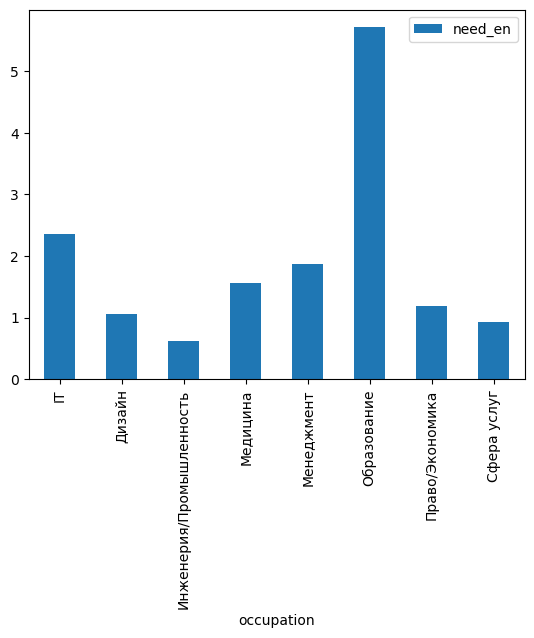

In [23]:
vacancy_inf = eng[['vacancy_id', 'occupation', 'need_en']].drop_duplicates()
(vacancy_inf[['occupation', 'need_en']].groupby('occupation').mean() * 100).plot.bar()

<Axes: xlabel='occupation'>

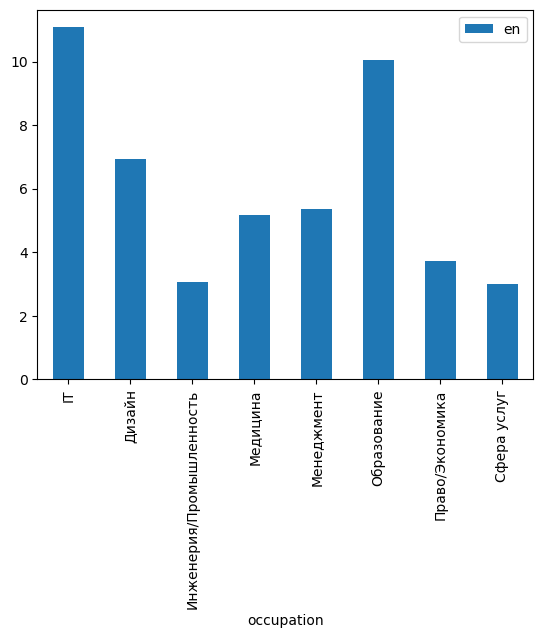

In [24]:
user_inf = eng[['resume_id', 'occupation', 'en']].drop_duplicates()
(user_inf[['occupation', 'en']].groupby('occupation').mean() * 100).plot.bar()

Теперь рассмотрим четыре сценария(NN - соискатель не знает англ и он не требуется, NY - соиск не знает, англ требуется, YN - соиск знает, не требуется, YY - соиск знает и требуется) в срезе каждой из сфер деятельности

In [25]:
eng = eng[eng.final_state != 'response']
eng.final_state = eng.final_state.map(lambda x: 1 if x == 'invitation' else 0)
eng['scenary'] = eng.apply((lambda x: ('Y' if x['en'] else 'N') + ('Y' if x['need_en'] else 'N')), 1)

In [26]:
gb = eng[['occupation', 'scenary', 'final_state']].groupby(['occupation', 'scenary']).mean()
gb

final_state
occupation               scenary             
IT                       NN          0.569047
                         NY          0.332268
                         YN          0.483267
                         YY          0.374302
Дизайн                   NN          0.701027
                         NY          0.406250
                         YN          0.516129
                         YY          0.000000
Инженерия/Промышленность NN          0.744266
                         NY          0.453333
                         YN          0.703297
                         YY          0.458333
Медицина                 NN          0.545495
                         NY          0.263158
                         YN          0.491525
                         YY          0.333333
Менеджмент               NN          0.672083
                         NY          0.466030
                         YN          0.633223
                         YY          0.528902
Образование              NN          0.675313
                         NY          0.500000
                         YN          0.644860
                         YY          0.516129
Право/Экономика          NN          0.553686
                         NY          0.357143
                         YN          0.497768
                         YY          0.348837
Сфера услуг              NN          0.775847
                         NY          0.613354
                         YN          0.697654
                         YY          0.611570

<Axes: xlabel='final_state', ylabel='occupation'>

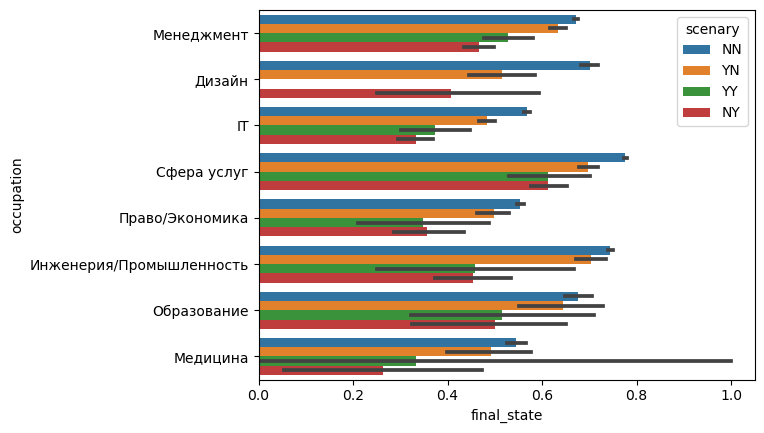

In [27]:
import seaborn as sns
sns.barplot(x='final_state', y='occupation', hue='scenary', data=eng, orient='h')

Заметим, что в сценариях NN, YN наибольший показатель приема в каждой из сфер. Незначительная разница между YY и NY во многих сферах может быть обусловлена тем, что у соискателя недостаточно высокий уровень английского языка, а также тем, что соискатель может не указывать английский в своих скиллах, но при подаче заявления а вакансию по умолчанию подразумевать то, что английский он знает.

В целом можно сделать предположение о том, что английский язык наиболее востребован в сферах образования, IT и менеджмента, что вполне ожидаемо, так как к последних двух сферах часто приходится работать с иностранцами, а в образовании очень популярна профессия именно учителя английского языка. Также можно предположить, что скорее всего на вакансию, где требуется английский будет сложнее устроиться, даже если вы его знаете. 

# Посмотрим на скиллы чуть подробнее

In [28]:
skills = []
for i in df.resume_skills_list:
    for j in i:
        if j:
            skills.append(j.lower())
skills = pd.Series(skills).value_counts()
list(skills[skills>5000].index)

['ответственность',
 'пользователь пк',
 'работа в команде',
 'организаторские навыки',
 'грамотная речь',
 'деловая переписка',
 'работа с большим объемом информации',
 'деловое общение',
 'обучаемость',
 'исполнительность',
 'работоспособность',
 'ведение переговоров',
 'телефонные переговоры',
 'управление персоналом',
 'коммуникабельность',
 'обучение персонала',
 'заключение договоров',
 'ms excel',
 'стрессоустойчивость',
 'умение работать в команде',
 'деловая коммуникация',
 'обучение и развитие',
 'ms word',
 'активные продажи',
 'английский язык',
 '1с: предприятие 8',
 'ms outlook',
 'навыки продаж',
 'руководство коллективом',
 'ms powerpoint',
 'водительское удостоверение категории b',
 'работа с оргтехникой',
 'поиск информации в интернет',
 'поиск и привлечение клиентов',
 'пунктуальность',
 'подбор персонала',
 'adobe photoshop',
 'управление продажами',
 'делопроизводство',
 'документооборот',
 'прямые продажи',
 'документальное сопровождение',
 'мотивация персонала',


In [29]:
soft_skills = ['ответственность', 'работа в команде', 'организаторские навыки', 'грамотная речь',
 'деловая переписка', 'работа с большим объемом информации', 'деловое общение', 'обучаемость',
 'исполнительность', 'работоспособность', 'ведение переговоров', 'телефонные переговоры',
 'управление персоналом', 'коммуникабельность', 'стрессоустойчивость', 'умение работать в команде',
 'деловая коммуникация', 'обучение и развитие', 'активные продажи', 'руководство коллективом',
 'пунктуальность', 'управление проектами', 'грамотность', 'навыки межличностного общения',
 'креативность', 'управленческие навыки', 'клиентоориентированность', 'умение работать в коллективе',
 'аналитическое мышление', 'управление командой', 'точность и внимательность к деталям',
 'целеустремленность', 'внимательность', 'копирайтинг', 'многозадачность', 'работа с возражениями',
 'навыки переговоров', 'навыки презентации', 'способность обучать других',
 'управление производственным персоналом', 'доброжелательность', 'урегулирование конфликтов',
 'планирование', 'быстрая обучаемость']
extra_skills=['пользователь пк', 'заключение договоров', 'ms excel', 'ms word', 'английский язык',
 'ms outlook', 'ms powerpoint', 'водительское удостоверение категории b', 'работа с оргтехникой',
 'проведение инвентаризаций', 'уверенный пользователь пк', 'договорная работа', 'составление договоров',
 'ведение отчетности', 'ведение групп в социальных сетях', 'работа с документами', 'работа с возражениями',
 'претензионная работа', 'навыки переговоров', 'офисная техника', 'обслуживание покупателей',
 'электронный документооборот', 'социальные сети', 'первичная документация', 'работа с жалобами клиентов',
 'навыки презентации', 'транспортная логистика', 'управление производственным персоналом',
 'оформление документации', 'продвижение в социальных группах', 'бумажный документооборот',]
# доп. скиллы - нельзя отнести ни к soft, ни к hard, но могут дать плюс в целом

In [30]:
def soft_count(l):
    res=0
    for i in l:
        if i and i in soft_skills:
            res+=1
    return res
skills_df = df.copy()
skills_df = skills_df[skills_df.vacancy_employment_type == 'full']
skills_df = skills_df[skills_df.final_state != 'response']
skills_df.final_state = skills_df.final_state.map(lambda x: 1 if x == 'invitation' else 0)

In [31]:
skills_df['soft_count'] = skills_df.resume_skills_list.map(soft_count)
skills_df = skills_df[skills_df.soft_count <= 10]

<Axes: xlabel='soft_count'>

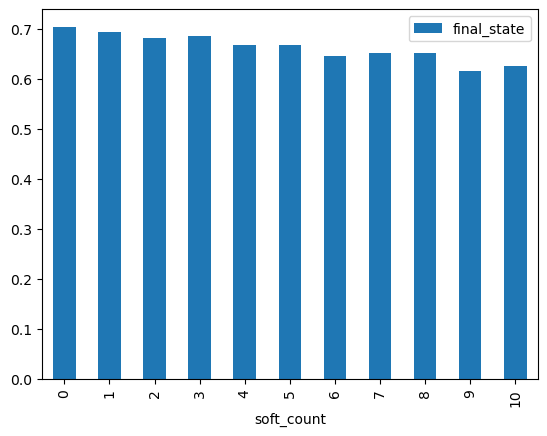

In [32]:
skills_df[['soft_count', 'final_state']].groupby('soft_count').mean().plot.bar()

In [33]:
# доля софтскиллов от всех
skills_df['soft_part'] = skills_df.soft_count / skills_df.resume_skills_list.map(lambda x: max(1, len(x)))

In [34]:
skills_df['soft_part'] = skills_df.soft_part.map(lambda x: round(x * 100) / 100)

<Axes: xlabel='soft_part'>

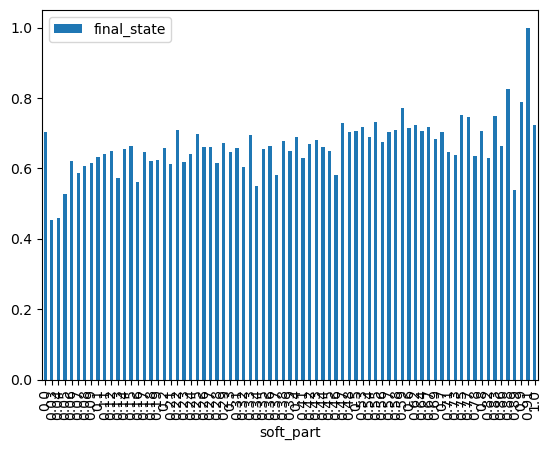

In [35]:
skills_df[['soft_part', 'final_state']].groupby('soft_part').mean().plot.bar()